In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_confusion_matrix

# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:

df_train = df_train.drop(columns=[
     'averageRating', 'originalTitle', 
])

df_test = df_test.drop(columns=[
     'averageRating', 'originalTitle', 
])

In [4]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)

In [5]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [6]:
X_train.shape

(103679, 21)

# Gradient Boosting

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [8]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [9]:
from sklearn.utils.class_weight import compute_sample_weight

# This replicates class_weight='balanced'
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


In [10]:
%%time

param_list = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1,],
    'max_depth': [3, 4, 5],
 
}

clf = GradientBoostingClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_list, n_iter=100, 
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),)

random_search.fit(X_train, y_train, sample_weight=sample_weights)
clf = random_search.best_estimator_

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))



c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy 0.39041296275458537
F1-score [0.25858516 0.47638487 0.33787437 0.46753559 0.3519666  0.2166295 ]
              precision    recall  f1-score   support

           0       0.18      0.49      0.26      1547
           1       0.49      0.46      0.48      9052
           2       0.44      0.28      0.34     11574
           3       0.55      0.40      0.47     14409
           4       0.31      0.41      0.35      6571
           5       0.14      0.53      0.22      1282

    accuracy                           0.39     44435
   macro avg       0.35      0.43      0.35     44435
weighted avg       0.45      0.39      0.40     44435

CPU times: total: 2d 42min 55s
Wall time: 2d 11h 50min 4s


In [11]:
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [13]:
results = pd.DataFrame(random_search.cv_results_)

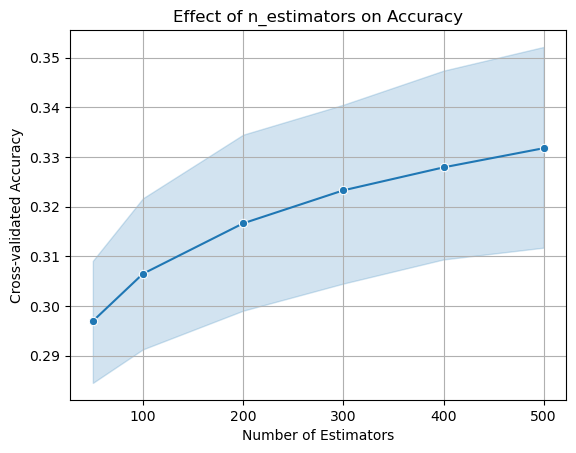

In [14]:
# Plot n_estimators vs. accuracy
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-validated Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.grid(True)
plt.show()

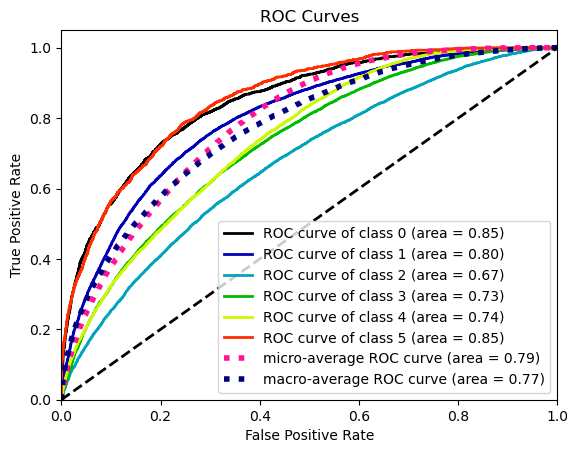

In [15]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

In [16]:
y_train_pred = clf.predict(X_train)

In [17]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

Train Accuracy 0.5330491227731748
Train F1-score [0.46149311 0.61058841 0.49806259 0.57927205 0.50496884 0.37177562]

Test Accuracy 0.39041296275458537
Test F1-score [0.25858516 0.47638487 0.33787437 0.46753559 0.3519666  0.2166295 ]
